In [39]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
from numpy.ma import masked_where

## User Defined Variables

In [82]:
FRF = '2' # if 1D, FRF = '1' & if 2D, FRF = '2'

survey = 'Oct8' # or 'Oct8'

FOLDER_NAME = 'FRF2D-2015100623-extended-2412214' # simulation folder
date = '20151006-23' # format = yyyymmdd-hh

TOTAL_TIME = 3640.00 # total time of simulation

Water_Level = 0.40

dx_FRF = 0.1 # FRF Cross-Shore resolution
dx_FUN = 1.0 # FUNWAVE Cross-Shore resolution

(1) Setup Directory Paths
----

In [83]:
pwd = os.getcwd()

## FRF LIDAR OBSERVATIONS:
FRF_path = os.path.join(pwd,'FRF_LIDAR_DATA','fdate_folder')
FRF_mwl_path = os.path.join(pwd,'FRF_LIDAR_DATA','mwl_FRF')

list_FRF = sorted(os.listdir(FRF_path))  # list all the folders inside FRF path
list_FRF.remove('.DS_Store') # eliminate .DS_Store from list
list_FRF.remove('figures') # eliminate figures from list

list_mwl_FRF = sorted(os.listdir(FRF_mwl_path))  # list all mwl files inside FRF_mwl path
list_mwl_FRF.remove('.DS_Store') # eliminate .DS_Store from list

## FUNWAVE SIMULATIONS:
assert FRF in ['1','2'],"Use FRF = '1' if 1D or FRF = '2' if 2D!"  
assert survey in ['Oct1','Oct8'],"Use survey = 'Oct1' if survey as taken on Oct1 or survey = 'Oct8' if survey as taken on Oct8!" 
if FRF == '1':
    project_Dir = os.path.join(pwd,'FRF1D')
    profile_i = 1 # i index of LIDAr profile in 1D
    PLOT_INTV = 0.14285  # plot interval of simulation
else:
    project_Dir = os.path.join(pwd,'FRF2D')
    PLOT_INTV = 1  # plot interval of simulation
    if survey == 'Oct8':
        profile_i = 195 # i index of LIDAr profile in Oct8-2D (if DY = 2m)
    else:
        profile_i = 36 # i index of LIDAr profile in Oct1-2D (if DY = 2m)

sim_Dir = os.path.join(project_Dir,FOLDER_NAME)
output_Dir = os.path.join(sim_Dir,'output')

plot_Dir = os.path.join(sim_Dir,'plots')
try:
    # Create target Directory
    os.mkdir(plot_Dir)
    print("Directory " , plot_Dir ,  " Created ") 
except FileExistsError:
    print("Directory " , plot_Dir ,  " already exists")

Directory  /Users/rdchlgs8/Desktop/FRF/post-process/FRF2D/FRF2D-2015100623-extended-2412214/plots  already exists


(2) Upload FUNWAVE's eta output as an eta_time_series
----

In [84]:
# upload bathy profile from depth.txt
dep = np.loadtxt(os.path.join(output_Dir,'dep.out'))[profile_i,:]*-1 + Water_Level

number_of_Eta = int(TOTAL_TIME/PLOT_INTV+1)

print('Loading a total of %d eta files for date = %s'% (number_of_Eta,date))

# create eta time series
eta_time_series = np.zeros([number_of_Eta,len(dep)]) # format = [time x downLineDistance]

for num in range(number_of_Eta):
    
    eta_File = 'eta_{0:0>5s}'.format(str(num+1))
    eta_path = os.path.join(output_Dir,eta_File)

    mask_File = 'mask_{0:0>5s}'.format(str(num+1))
    mask_path = os.path.join(output_Dir,mask_File)

    mask = np.loadtxt(mask_path)[profile_i,:] 
    
    eta = np.loadtxt(eta_path)[profile_i,:]

    mask_index = np.where( mask == 0.0 )
    eta[mask_index] = 'NaN'
    
    eta_time_series[num,:] = eta[:]
    
    

Loading a total of 3641 eta files for date = 20151006-23


## (3) Upload LIDAR water surface elevation and MWL data

In [85]:
for i, file in enumerate(list_FRF):
    if file[:11] == date:  
        water_File_path = os.path.join(FRF_path,file,'waterGridFiltered.dat') # water section of profile
        water = np.loadtxt(water_File_path,delimiter=',')[:,28:]
        water_nan = np.ma.array(water, mask=np.isnan(water)) 
        print('Uploading:',water_File_path )
    else:
        pass

mwl_date = date.replace("-", "")
for i_mwl, file_mwl in enumerate(list_mwl_FRF):
    if file_mwl[4:14] == mwl_date:  
        mwl_File_path = os.path.join(FRF_mwl_path,file_mwl) # lidar mwl 
        mwl = np.genfromtxt(mwl_File_path,delimiter='')[28:]
        print('Uploading:',mwl_File_path )
    else:
        pass

Uploading: /Users/rdchlgs8/Desktop/FRF/post-process/FRF_LIDAR_DATA/fdate_folder/20151006-2300-01/waterGridFiltered.dat
Uploading: /Users/rdchlgs8/Desktop/FRF/post-process/FRF_LIDAR_DATA/mwl_FRF/mwl-2015100623.txt


## (4) Plot Scatter 

In [86]:
[time, downLineDistanceFRF] = np.shape(water_nan) # FRF water file dimensions = [time x downLineDistance]

xinit_FRF = 0.0
xfinal_FRF = downLineDistanceFRF/(dx_FRF**-1)
x_FRF = np.arange(xinit_FRF,xfinal_FRF,dx_FRF) # FRF cross-shore distance vector

xinit_FUN = 0.0
xfinal_FUN = len(dep)*dx_FUN
x_FUN = np.arange(xinit_FUN,xfinal_FUN,dx_FUN) # FUNWAVE cross-shore distance vector


# plot complete profile
fig = plt.figure(figsize=(15.0,10.0))
ax = fig.add_subplot(1, 1, 1)

plt.plot(x_FRF,mwl,'w--',linewidth =1.0)
plt.plot(x_FUN[:170],dep[:170],'k',linewidth =1.0)
for i in range(time):
    plt.scatter(x_FRF,water_nan[i,:],c='goldenrod',s=0.5)
    
for j in range(number_of_Eta):
    plt.scatter(x_FUN[:170],eta_time_series[j,:170]+Water_Level,c='b',s=0.5)

plt.axis([xinit_FUN,160,-4,8])

x_major_ticks = np.arange(0, 160, 20)
x_minor_ticks = np.arange(0, 160, 10)
y_major_ticks = np.arange(-4, 8, 2)
y_minor_ticks = np.arange(-4, 8, 1)

ax.set_xticks(x_major_ticks)
ax.set_xticks(x_minor_ticks, minor=True)
ax.set_yticks(y_major_ticks)
ax.set_yticks(y_minor_ticks, minor=True)
ax.grid(linestyle=':',which='both')

plt.ylabel('Elevation (m)')
plt.xlabel('Cross-shore distance (m)')

plt.savefig(os.path.join(plot_Dir,'ETA_scatter_%s.png'%(date)), dpi=300)

plt.close(fig)

## (5) Plot Scatter zoom

In [87]:
# plot profile zoom
fig_zoom = plt.figure(figsize=(18.0,10.0))
ax_zoom = fig_zoom.add_subplot(1, 1, 1)

plt.plot(x_FRF,mwl,'w--',linewidth =1.0)
plt.plot(x_FUN[:170],dep[:170],'k',linewidth =1.0)
for i in range(time):
    plt.scatter(x_FRF,water_nan[i,:],c='goldenrod',s=0.5)
    
for j in range(number_of_Eta):
    plt.scatter(x_FUN[:170],eta_time_series[j,:170]+Water_Level,c='b',s=2.0)

plt.axis([0,30,0,7])

x_major_ticks_zoom = np.arange(0, 30, 5)
x_minor_ticks_zoom = np.arange(0, 30, 2.5)
y_major_ticks_zoom = np.arange(0,7, 1)
y_minor_ticks_zoom = np.arange(0,7, 0.5)

ax_zoom.set_xticks(x_major_ticks_zoom)
ax_zoom.set_xticks(x_minor_ticks_zoom, minor=True)
ax_zoom.set_yticks(y_major_ticks_zoom)
ax_zoom.set_yticks(y_minor_ticks_zoom, minor=True)

# And a corresponding grid
ax_zoom.grid(linestyle=':',which='both')

plt.ylabel('Elevation (m)')
plt.xlabel('Cross-shore distance (m)')

plt.savefig(os.path.join(plot_Dir,'ETA_scatter_zoom_%s.png'%(date)), dpi=300)

plt.close(fig_zoom)

## (6) Plot Boxplot

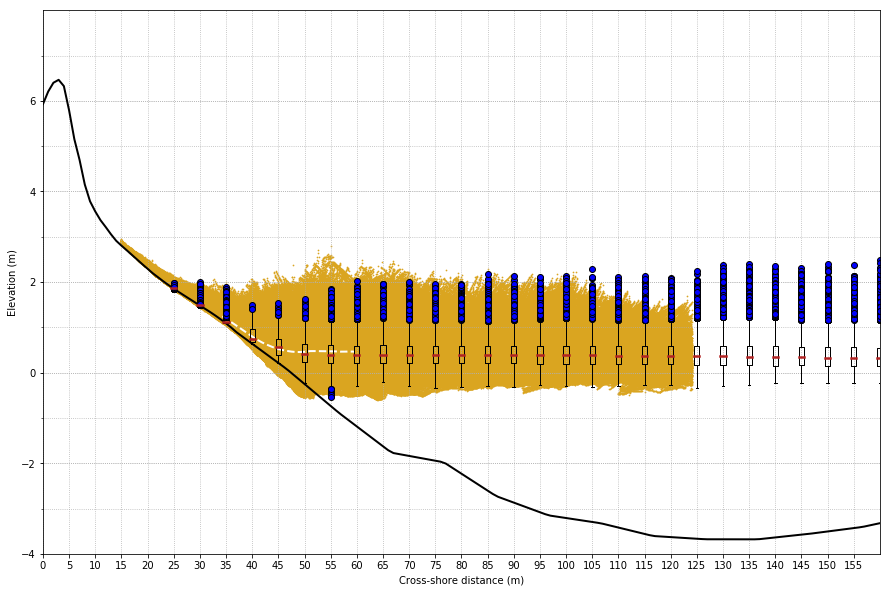

In [88]:
fig = plt.figure(figsize=(15.0,10.0))
ax = fig.add_subplot(1, 1, 1)

plt.plot(x_FRF,mwl,'w--',linewidth =2.0)
plt.plot(x_FUN[:170],dep[:170],'k',linewidth =2.0)
for i in range(time):
    plt.scatter(x_FRF,water_nan[i,:],c='goldenrod',s=0.5)

# Filter data using np.isnan
mask2 = ~np.isnan(eta_time_series)
filtered_data = [d[m]+Water_Level for d, m in zip(eta_time_series.T, mask2.T)]
    
blue_dots = dict(markerfacecolor='b', marker='o')
median = dict(linewidth=2.5,color='firebrick')
ax.boxplot(filtered_data[0::5],positions=x_FUN[0::5],widths=1.0,flierprops=blue_dots,medianprops=median)

plt.axis([xinit_FUN,160,-4,8])

x_major_ticks = np.arange(0,160,5)

y_major_ticks = np.arange(-4, 8, 2)
y_minor_ticks = np.arange(-4, 8, 1)

ax.set_xticks(x_major_ticks)
ax.set_xticklabels(x_major_ticks.astype(int))
ax.set_yticks(y_major_ticks)
ax.set_yticks(y_minor_ticks, minor=True)
ax.grid(linestyle=':',which='both')

plt.ylabel('Elevation (m)')
plt.xlabel('Cross-shore distance (m)')

plt.savefig(os.path.join(plot_Dir,'ETA_boxplot_%s.png'%(date)), dpi=300)